In [4]:
# Install system + python packages (run once)
!apt-get update -qq
!apt-get install -y -qq tesseract-ocr libtesseract-dev

!pip install -q --upgrade pip
!pip install -q pytesseract easyocr pandas numpy scikit-learn xgboost shap matplotlib seaborn joblib openpyxl


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# Imports
import os
from pathlib import Path
import glob
import json
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report
import xgboost as xgb
import joblib

# OCR (optional)
import pytesseract
import easyocr

# SHAP
import shap

# Colab Drive helper
from google.colab import drive, files


In [3]:
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Correct project folder (this is a directory)
PROJECT = "credit_shap_project"

BASE = Path(f"/content/drive/MyDrive/{PROJECT}")
DATA_DIR = BASE / "data"
IMAGES_DIR = BASE / "images"
OUTPUTS_DIR = BASE / "outputs"

# Create folders
for p in [BASE, DATA_DIR, IMAGES_DIR, OUTPUTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project base:", BASE)
print("Put data files into:", DATA_DIR)
print("Put screenshots into:", IMAGES_DIR)
print("Notebook will save outputs into:", OUTPUTS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project base: /content/drive/MyDrive/credit_shap_project
Put data files into: /content/drive/MyDrive/credit_shap_project/data
Put screenshots into: /content/drive/MyDrive/credit_shap_project/images
Notebook will save outputs into: /content/drive/MyDrive/credit_shap_project/outputs


In [5]:
# Attempt to auto-detect a dataset file in data/
csvs = sorted(glob.glob(str(DATA_DIR / "*.csv")))
xls = sorted(glob.glob(str(DATA_DIR / "*.xls*")))

if csvs:
    data_path = csvs[0]
    print("Loading CSV:", data_path)
    df = pd.read_csv(data_path)
elif xls:
    data_path = xls[0]
    print("Loading Excel:", data_path)
    df = pd.read_excel(data_path)
else:
    data_path = None
    df = None
    print("No dataset found in", DATA_DIR, " — upload dataset.csv or dataset.xlsx into that folder.")

if df is not None:
    print("Data loaded. Shape:", df.shape)
    display(df.head())


Loading CSV: /content/drive/MyDrive/credit_shap_project/data/UCI_Credit_Card.csv
Data loaded. Shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
# Quick inspection
if df is None:
    raise SystemExit("Upload the dataset to /content/drive/My Drive/credit_shap_project/data/ and re-run.")
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum())

# Heuristic to pick target:
possible_targets = [c for c in df.columns if c.lower() in ('target','label','default','loan_status','is_default','defaulted')]
if possible_targets:
    target_col = possible_targets[0]
else:
    # fallback: ask the user — but since we must not wait, pick last column as target
    target_col = df.columns[-1]
print("\nUsing target column:", target_col)

# If target is numeric but encodes classes as 0/1, keep as is; otherwise convert
y = df[target_col]
print("Target sample values & dtype:", y.unique()[:10], y.dtype)


Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']

Missing values per column:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      

In [9]:
# Define X and y (drop target column from X)
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert common string indicators to numeric (if necessary)
# E.g., sometimes target has 'yes'/'no' or 'Y'/'N'
if y.dtype == 'object':
    y = y.str.strip().str.lower().map({'yes':1,'y':1,'true':1,'1':1,'no':0,'n':0,'false':0,'0':0}).fillna(y)

# Final ensure y is numeric for binary classification when possible
try:
    y = pd.to_numeric(y)
except:
    pass

# Train/test split (stratify if binary)
stratify_arg = y if (y.nunique() <= 2) else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=stratify_arg)

# Column types
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')


Numeric cols: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Categorical cols: []
Train shape: (24000, 24) Test shape: (6000, 24)


In [10]:
# Choose model (XGBoost classifier) and small grid for speed
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_clf)
])

# Use F1 as primary metric for binary classification; else use balanced_accuracy
if y_train.nunique() == 2:
    scoring_metric = 'f1'
else:
    scoring_metric = 'balanced_accuracy'

param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.1, 0.01]
}

grid = GridSearchCV(pipe, param_grid, cv=3, scoring=scoring_metric, n_jobs=1, verbose=2)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score ({}):".format(scoring_metric), grid.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50; total time=   3.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=50; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=50; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=50; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=50; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=100; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=100; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.1, model__max_depth=6, model__n_estimators=100; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=6, model__n_estimators=50; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=6, model__n_estimators=50; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=6, model__n_estimators=50; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100; total time=   0.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END model__learning_rate=0.01, model__max_depth=6, model__n_estimators=100; total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best CV score (f1): 0.4771129474790816


Accuracy: 0.819
F1: 0.4681684622918707
Precision: 0.6685314685314685
Recall: 0.3602110022607385
ROC AUC: 0.7796780588385458


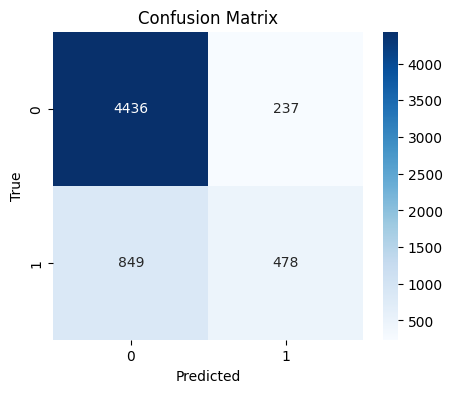

Saved: /content/drive/MyDrive/credit_shap_project/outputs/confusion_matrix.png


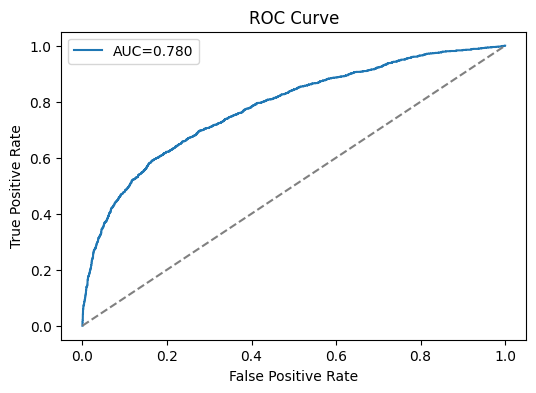

Saved: /content/drive/MyDrive/credit_shap_project/outputs/roc_curve.png
Saved metrics to /content/drive/MyDrive/credit_shap_project/outputs/metrics.json
Saved model to /content/drive/MyDrive/credit_shap_project/outputs/model.joblib
Saved predictions to /content/drive/MyDrive/credit_shap_project/outputs/predictions.csv


In [11]:
# Evaluate best model
best = grid.best_estimator_
y_pred = best.predict(X_test)
results = {}

if y_test.nunique() == 2:
    results['accuracy'] = float(accuracy_score(y_test, y_pred))
    results['f1'] = float(f1_score(y_test, y_pred))
    results['precision'] = float(precision_score(y_test, y_pred))
    results['recall'] = float(recall_score(y_test, y_pred))
    try:
        y_proba = best.predict_proba(X_test)[:,1]
        results['roc_auc'] = float(roc_auc_score(y_test, y_proba))
    except:
        results['roc_auc'] = None

    print("Accuracy:", results['accuracy'])
    print("F1:", results['f1'])
    print("Precision:", results['precision'])
    print("Recall:", results['recall'])
    if results['roc_auc'] is not None:
        print("ROC AUC:", results['roc_auc'])

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    cm_path = OUTPUTS_DIR / "confusion_matrix.png"
    plt.savefig(cm_path, bbox_inches='tight')
    plt.show()
    print("Saved:", cm_path)

    # ROC curve (if proba exists)
    try:
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_path = OUTPUTS_DIR / "roc_curve.png"
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"AUC={results['roc_auc']:.3f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.title("ROC Curve")
        plt.savefig(roc_path, bbox_inches='tight')
        plt.show()
        print("Saved:", roc_path)
    except Exception as e:
        print("ROC plot skipped:", e)

else:
    # regression-like metrics if not binary
    from sklearn.metrics import mean_squared_error, r2_score
    results['rmse'] = float(mean_squared_error(y_test, y_pred, squared=False))
    results['r2'] = float(r2_score(y_test, y_pred))
    print("RMSE:", results['rmse'], "R2:", results['r2'])

# Save metrics, model, and predictions
metrics_path = OUTPUTS_DIR / "metrics.json"
with open(metrics_path, "w") as fh:
    json.dump(results, fh, indent=2)
print("Saved metrics to", metrics_path)

model_path = OUTPUTS_DIR / "model.joblib"
joblib.dump(best, model_path)
print("Saved model to", model_path)

preds_df = pd.DataFrame({"true": y_test.values, "pred": y_pred})
preds_csv = OUTPUTS_DIR / "predictions.csv"
preds_df.to_csv(preds_csv, index=False)
print("Saved predictions to", preds_csv)


Number of final features: 24


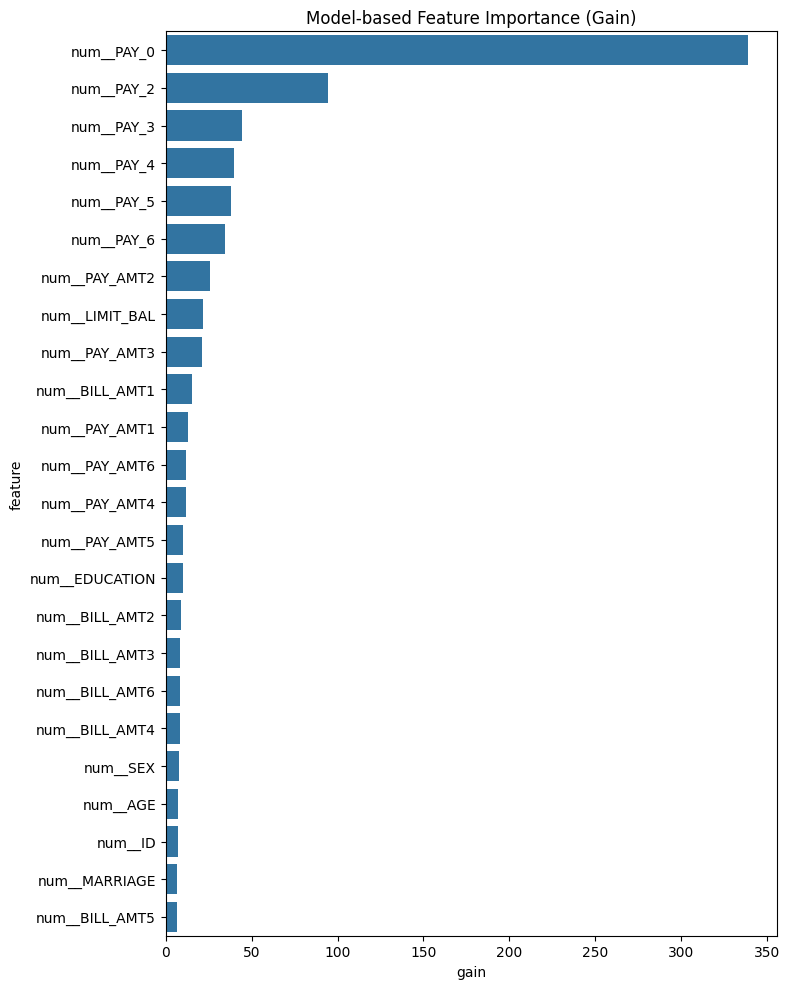

Saved feature importance to: /content/drive/MyDrive/credit_shap_project/outputs/feature_importance.png


In [14]:
from sklearn.utils.validation import check_is_fitted

preprocessor = best.named_steps['preprocessor']
model = best.named_steps['model']

# Make sure preprocessor is fitted (Pipeline.fit() does this automatically)
check_is_fitted(preprocessor)

# 1. Get full feature names after preprocessing
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Fallback for older scikit-learn versions
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == "num":
            # numeric columns pass through
            feature_names.extend(cols)
        elif name == "cat":
            # categorical columns expanded by OHE
            ohe = transformer.named_steps['onehot']
            feature_names.extend(ohe.get_feature_names_out(cols))

print("Number of final features:", len(feature_names))

# 2. Extract XGBoost feature importance
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

importance_data = []
for key, val in importance_dict.items():
    idx = int(key[1:])  # XGBoost uses "f0", "f1", ...
    if idx < len(feature_names):
        importance_data.append((feature_names[idx], val))

# 3. Create DataFrame
imp_df = pd.DataFrame(importance_data, columns=["feature", "gain"])
imp_df = imp_df.sort_values("gain", ascending=False).head(30)

# 4. Plot & save
plt.figure(figsize=(8, 10))
sns.barplot(x="gain", y="feature", data=imp_df)
plt.title("Model-based Feature Importance (Gain)")
plt.tight_layout()

fi_path = OUTPUTS_DIR / "feature_importance.png"
plt.savefig(fi_path, bbox_inches="tight")
plt.show()

print("Saved feature importance to:", fi_path)


In [15]:
# SHAP explanations (TreeExplainer works with XGBoost). For speed, sample up to 200 rows.
# Prepare transformed train data to initialize explainer
print("Computing SHAP values — might take a minute for large data.")
# Transform some training data for background
X_train_trans = best.named_steps['preprocessor'].transform(X_train)
# Explainer on model
explainer = shap.TreeExplainer(best.named_steps['model'])
# Sample test rows to explain (choose up to 200)
sample_size = min(200, X_test.shape[0])
sample_idx = np.random.choice(range(X_test.shape[0]), size=sample_size, replace=False)
X_sample = X_test.iloc[sample_idx]
X_sample_trans = best.named_steps['preprocessor'].transform(X_sample)
# Compute shap_values
shap_values = explainer.shap_values(X_sample_trans)

# Summary plot (global)
shap.summary_plot(shap_values, X_sample_trans, feature_names=feature_names, show=False)
shap_summary_path = OUTPUTS_DIR / "shap_summary.png"
plt.savefig(shap_summary_path, bbox_inches='tight')
plt.close()
print("Saved SHAP global summary to", shap_summary_path)

# Save local explanations (force/waterfall) for 3-5 representative cases:
# We'll select indices for: a true positive, false positive, false negative, true negative (if present)
# Recompute predictions on X_test to find these indices
y_test_pred = best.predict(X_test)
test_df = X_test.copy()
test_df['true'] = y_test.values
test_df['pred'] = y_test_pred

# Identify indices by case
def find_index(condition):
    idxs = test_df[condition].index.tolist()
    return idxs[0] if idxs else None

cases = {
    "true_positive": ( (test_df['true']==1) & (test_df['pred']==1) ),
    "false_positive": ( (test_df['true']==0) & (test_df['pred']==1) ),
    "false_negative": ( (test_df['true']==1) & (test_df['pred']==0) ),
    "true_negative": ( (test_df['true']==0) & (test_df['pred']==0) )
}
selected = []
for k, cond in cases.items():
    idx = find_index(cond)
    if idx is not None:
        selected.append(idx)
# If fewer than 3 selected, fill with 3 random sample indices
if len(selected) < 3:
    extra = [i for i in X_test.index if i not in selected]
    selected += extra[: (3-len(selected)) ]

selected = selected[:5]  # max 5
print("Selected indices for local SHAP plots:", selected)

# Save local plots
for i, idx in enumerate(selected, start=1):
    row = X_test.loc[[idx]]
    row_trans = best.named_steps['preprocessor'].transform(row)
    sv = explainer.shap_values(row_trans)
    # Waterfall or force plot
    try:
        shap.plots.waterfall(sv[0] if isinstance(sv, list) else sv, max_display=10, show=False)
        local_png = OUTPUTS_DIR / f"shap_local_{i}.png"
        plt.savefig(local_png, bbox_inches='tight')
        plt.close()
        print("Saved local SHAP waterfall:", local_png)
    except:
        # fallback to bar plot of feature contributions
        arr = sv[0] if isinstance(sv, list) else sv
        # convert to 1D array for that sample
        vals = np.array(arr).reshape((arr.shape[-1],))
        # top features:
        top_idx = np.argsort(-np.abs(vals))[:10]
        top_feats = [feature_names[j] for j in top_idx]
        top_vals = vals[top_idx]
        plt.figure(figsize=(6,4))
        sns.barplot(x=top_vals, y=top_feats)
        plt.title(f"Local SHAP approx (idx {idx})")
        local_png = OUTPUTS_DIR / f"shap_local_{i}.png"
        plt.savefig(local_png, bbox_inches='tight')
        plt.close()
        print("Saved fallback local SHAP plot:", local_png)

    # Try to save interactive force plot HTML
    try:
        shap.initjs()
        fp = shap.force_plot(explainer.expected_value if hasattr(explainer, 'expected_value') else explainer.base_value, sv[0] if isinstance(sv, list) else sv, matplotlib=False, feature_names=feature_names)
        html_path = OUTPUTS_DIR / f"shap_force_{i}.html"
        shap.save_html(str(html_path), fp)
        print("Saved interactive SHAP force plot:", html_path)
    except Exception as e:
        print("Could not save interactive force plot for idx", idx, ":", e)


Computing SHAP values — might take a minute for large data.
Saved SHAP global summary to /content/drive/MyDrive/credit_shap_project/outputs/shap_summary.png
Selected indices for local SHAP plots: [3560, 17778, 2156, 6907]
Saved fallback local SHAP plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_local_1.png


Saved interactive SHAP force plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_force_1.html
Saved fallback local SHAP plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_local_2.png


Saved interactive SHAP force plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_force_2.html
Saved fallback local SHAP plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_local_3.png


Saved interactive SHAP force plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_force_3.html
Saved fallback local SHAP plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_local_4.png


Saved interactive SHAP force plot: /content/drive/MyDrive/credit_shap_project/outputs/shap_force_4.html


In [16]:
# Save templates for the textual deliverables you must submit.
technical_summary = f"""
PROJECT: Interpretable ML - SHAP Analysis of Credit Risk

Brief approach:
1. Preprocessed numeric features (median imputation + scaling) and categorical features (most-frequent imputation + one-hot).
2. Trained an XGBoost classifier with hyperparameter tuning (GridSearchCV) optimizing {scoring_metric}.
3. Evaluated model on test set using accuracy, F1, precision, recall and ROC-AUC (when available).
4. Compared model-specific feature importance with SHAP global summary and generated local SHAP explanations for 3-5 representative loans.
"""

three_local_template = """
Local SHAP explanations (3 cases) - For each case include:
- Case index: <index>
- True label / Predicted label: <true>/<pred>
- Top 3 positive features (pushing towards default): feature1 (value, SHAP contribution), ...
- Top 3 negative features (pushing away from default): featureA (value, SHAP contribution), ...
- Short explanation (2-3 sentences) on why model made this decision.
"""

final_analysis = """
Final analysis (<= 500 words) — Business implications:
- Summarize how top features influence default risk.
- Note any fairness concerns (e.g., feature X disproportionately impacts demographic group Y).
- Suggested actions for lending officers: e.g., use feature signals to trigger manual review, collect missing data, adjust thresholds for fairness.
"""

# Save to files
with open(OUTPUTS_DIR / "technical_summary.txt", "w") as f:
    f.write(technical_summary)
with open(OUTPUTS_DIR / "local_shap_interpretation_template.txt", "w") as f:
    f.write(three_local_template)
with open(OUTPUTS_DIR / "final_analysis_template.txt", "w") as f:
    f.write(final_analysis)

print("Saved textual templates to outputs folder. Fill the templates with values from model output & SHAP plots.")
print("Files:", list((OUTPUTS_DIR).glob("*")))


Saved textual templates to outputs folder. Fill the templates with values from model output & SHAP plots.
Files: [PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/confusion_matrix.png'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/roc_curve.png'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/metrics.json'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/model.joblib'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/predictions.csv'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/feature_importance.png'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/shap_summary.png'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/shap_local_1.png'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/shap_force_1.html'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/shap_local_2.png'), PosixPath('/content/drive/MyDrive/credit_shap_project/outputs/shap_

In [17]:
print("Files saved to your Drive outputs folder:", OUTPUTS_DIR)
print("\nFiles you MUST include in your submission (recommended filenames):")
files_to_include = [
    "model.joblib",
    "predictions.csv",
    "metrics.json",
    "confusion_matrix.png",
    "roc_curve.png",
    "feature_importance.png",
    "shap_summary.png",
    "shap_local_1.png", "shap_local_2.png", "shap_local_3.png",
    "shap_force_1.html", "shap_force_2.html", "shap_force_3.html",
    "technical_summary.txt",
    "local_shap_interpretation_template.txt",
    "final_analysis_template.txt"
]
for f in files_to_include:
    print("-", f)

print("\nHow to download from Colab: Option A (fast, GUI):")
print(" -> Left Files pane -> 'Drive' -> My Drive ->", PROJECT, "-> outputs -> right click file -> Download")
print("\nOption B (direct from notebook): sample code to download a single file")
print("from google.colab import files; files.download('/content/drive/My Drive/{}/outputs/model.joblib')".format(PROJECT))


Files saved to your Drive outputs folder: /content/drive/MyDrive/credit_shap_project/outputs

Files you MUST include in your submission (recommended filenames):
- model.joblib
- predictions.csv
- metrics.json
- confusion_matrix.png
- roc_curve.png
- feature_importance.png
- shap_summary.png
- shap_local_1.png
- shap_local_2.png
- shap_local_3.png
- shap_force_1.html
- shap_force_2.html
- shap_force_3.html
- technical_summary.txt
- local_shap_interpretation_template.txt
- final_analysis_template.txt

How to download from Colab: Option A (fast, GUI):
 -> Left Files pane -> 'Drive' -> My Drive -> credit_shap_project -> outputs -> right click file -> Download

Option B (direct from notebook): sample code to download a single file
from google.colab import files; files.download('/content/drive/My Drive/credit_shap_project/outputs/model.joblib')
